In [3]:
from google.colab import files
uploaded = files.upload()


Saving CA_users_c.csv to CA_users_c.csv


In [4]:
!pip install scikit-surprise
from surprise import SVD, SVDpp


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 771 kB 3.9 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp38-cp38-linux_x86_64.whl size=2626450 sha256=cd06a6bcb8560f74bbca524e90345719b4dfcf8a1f8282a9d1d43365a49c93fb
  Stored in directory: /root/.cache/pip/wheels/af/db/86/2c18183a80ba05da35bf0fb7417aac5cddbd93bcb1b92fd3ea
Successfully built scikit-surprise


In [5]:
import pandas as pd
from surprise import Dataset, Reader
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import KFold
import matplotlib.pyplot as plt


#Creating Dataframes

In [6]:
reviews = pd.read_csv('California_reviews_c.csv', usecols= ['business_id', 'stars', 'review_id', 'user_id'])
business = pd.read_csv('business.csv', usecols= ['business_id', 'name'])
users = pd.read_csv('CA_users_c.csv', usecols= ['user_id', 'is_elite'])

Since users and business dataframe both have the same column names we will update them accordingly

In [7]:
users = users.rename(columns = { 'name': 'Username' })
business = business.rename(columns = { 'name': 'Restaurant name' })
reviews.columns
reviews.head()

,review_id,user_id,business_id,stars
0,SGVGJQ2EiAumz1ofc2T54g,vaAEyqOPZcn_3F-1nzsenQ,KC8_Rx4Orlsz8LIonCYXsA,3
1,5VWz3KmMp4mq9agrL_sWZQ,Y-SzX4gmeVqu1_JSjTx7RA,9u79dIXLQzmt9rnOZEnBaQ,5
2,OBgljJsqYKQihXC1q_e5rQ,FczCp38lpeYAQRCL9PQ5rw,9u79dIXLQzmt9rnOZEnBaQ,5
3,HJCjJcCkDEJ5yfbIdLuAXQ,hr4ZCUwACcidRjnnjZVxZQ,v4AMcIZ--hXZuJIg3luUgg,5
4,7NUfmZ5Kfr6Gl9IG8j8sAQ,4FXn5evsrPcGnYa1FsLGmw,sor6oj-nuslOcSx7di4urA,5


In [8]:
business.columns

Index(['business_id', 'Restaurant name'], dtype='object')

In [9]:
users.columns

Index(['user_id', 'is_elite'], dtype='object')

In [10]:
users.head()

,user_id,is_elite
0,UX5F5uklksvo-MTPFMD_kQ,False
1,DKg1g4YdyJE5VnSKE3A8xQ,False
2,rAwpi3P0xp-3S6Fzgjpvnw,False
3,UdKQcwk0kLf4AXtKGDvw4w,False
4,rue63aaJc5qpmruNlML-Lg,False


##Elite Reviews Only


In [11]:
elite_reviews_df = reviews.merge(users, how='left', on=['user_id'], indicator=True)
elite_reviews_df.shape
     

(53562, 6)

In [12]:

elite_reviews_df = elite_reviews_df.loc[elite_reviews_df['is_elite'] == True]
elite_reviews_df.shape
     

(2042, 6)

In [13]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, business id and stars (in that order).
data = Dataset.load_from_df(elite_reviews_df[['user_id', 'business_id', 'stars']], reader)

#Collaborative filtering using cross validation and hyperparameter tuning


#SVD

In [14]:
SVD_rmses = []
kfolds_SVD = [3,5,6]
n_split_to_best_param_grid = dict()
n_split_to_best_rmse = dict()

##Performing cross validations with different folds

In [15]:
def crossValidation(nsplit,algo, param_grid):
    kf = KFold(n_splits=nsplit, random_state=2,shuffle = True)
    return GridSearchCV(algo_class=algo, param_grid = param_grid, measures=['rmse'], cv=kf)

##Calculating the best paramters for SVD model to fetch best RMSE score

In [16]:
def SVD_hyperparamter_tuning(kfolds):
  param_grid_SVD = {
  'n_factors':[5,8,10,15,20,25],
  'n_epochs': [10, 20, 30, 40], 
  'lr_all': [0.005, 0.007],
  'reg_all': [0.01,0.03,0.05,0.07],
  }
  for elem in kfolds_SVD:
    gs_model = crossValidation(elem, SVD, param_grid_SVD)
    gs_model.fit(data)
    print(f"With kFold as {elem}: ", gs_model.best_params)
    n_split_to_best_param_grid[elem] = gs_model.best_params
    print(f"With kFold as {elem}: ", gs_model.best_score['rmse'])
    n_split_to_best_rmse[elem] = gs_model.best_score['rmse']

In [17]:
SVD_hyperparamter_tuning(kfolds_SVD)


With kFold as 3:  {'rmse': {'n_factors': 25, 'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.01}}
With kFold as 3:  0.7565618365822441
With kFold as 5:  {'rmse': {'n_factors': 25, 'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.01}}
With kFold as 5:  0.6971805327617142
With kFold as 6:  {'rmse': {'n_factors': 25, 'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.01}}
With kFold as 6:  0.647510890106997


In [18]:
print(n_split_to_best_param_grid)

{3: {'rmse': {'n_factors': 25, 'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.01}}, 5: {'rmse': {'n_factors': 25, 'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.01}}, 6: {'rmse': {'n_factors': 25, 'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.01}}}


##1. Training the model over the trainset with the hyperparamters
##2. Evaluating the model over the testset to check how does it perform

In [19]:
def train_and_test_model():
  SVD_rmses = []
  for n_split,param_grid in n_split_to_best_param_grid.items():
    n_factors, n_epochs, lr_all, reg_all = fetch_params(param_grid['rmse'])
    kf = KFold(n_splits=n_split)
    algo = SVD(n_factors = n_factors, n_epochs = n_epochs, lr_all = lr_all, reg_all = reg_all)
    scores = []
    for trainset, testset in kf.split(data):
        # train and test algorithm.
        algo.fit(trainset)
        predictions = algo.test(testset)
        # Compute and print Root Mean Squared Error
        print(f"RMSE for {n_split}:")
        rmse = accuracy.rmse(predictions)
        scores.append(rmse)
        # print(f"RMSE for {n_split}: ",rmse)
    SVD_rmses.append(min(scores))
  return SVD_rmses

In [20]:
def fetch_params(param_grid):
    return param_grid['n_factors'], param_grid['n_epochs'], param_grid['lr_all'], param_grid['reg_all']

In [21]:
SVD_rmses = train_and_test_model()

RMSE for 3:
RMSE: 0.8203
RMSE for 3:
RMSE: 0.7339
RMSE for 3:
RMSE: 0.7003
RMSE for 5:
RMSE: 0.7188
RMSE for 5:
RMSE: 0.6295
RMSE for 5:
RMSE: 0.6088
RMSE for 5:
RMSE: 0.7277
RMSE for 5:
RMSE: 0.6943
RMSE for 6:
RMSE: 0.6472
RMSE for 6:
RMSE: 0.6336
RMSE for 6:
RMSE: 0.5991
RMSE for 6:
RMSE: 0.6617
RMSE for 6:
RMSE: 0.6694
RMSE for 6:
RMSE: 0.6202


In [22]:
print(SVD_rmses)
def plot(kfolds, rmses, algo):
  plt.plot(kfolds, rmses)
  plt.ylabel('RMSE Scores')
  plt.xlabel('k splits')
  plt.savefig(f"{algo}_RMSE_to_k_splits.png")

[0.700310977314118, 0.6087816598302225, 0.5990637441198243]


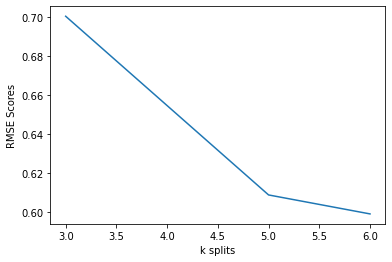

In [23]:
kfolds_SVD = [3,5,6]
plot(kfolds_SVD, SVD_rmses, "SVD")

##2. SVDpp

In [24]:
SVDpp_rmses = []
kfolds_SVDpp = [3,5,6]
n_split_to_best_param_grid_SVDpp = dict()
n_split_to_best_rmse_SVDpp = dict()
     

In [25]:
def SVDpp_hyperparamter_tuning(kfolds):
  param_grid_SVDpp = {
    'n_factors':[5,8,10,15,20],
    'n_epochs': [20,30,40], 
    'lr_all': [0.005, 0.007],
    'reg_all': [0.05,0.07],
  }
  for elem in kfolds:
    gs_model = crossValidation(elem, SVDpp, param_grid_SVDpp)
    gs_model.fit(data)
    print(f"With kFold as {elem}: ", gs_model.best_params)
    n_split_to_best_param_grid_SVDpp[elem] = gs_model.best_params
    print(f"With kFold as {elem}: ", gs_model.best_score['rmse'])
    n_split_to_best_rmse_SVDpp[elem] = gs_model.best_score['rmse']

In [26]:
SVDpp_hyperparamter_tuning(kfolds_SVDpp)

With kFold as 3:  {'rmse': {'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.05}}
With kFold as 3:  0.7714494319222389
With kFold as 5:  {'rmse': {'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.05}}
With kFold as 5:  0.7049074938871361
With kFold as 6:  {'rmse': {'n_factors': 20, 'n_epochs': 40, 'lr_all': 0.007, 'reg_all': 0.05}}
With kFold as 6:  0.670767979695544


In [27]:
def train_and_test_model_SVDpp():
  SVD_rmsespp = []
  for n_split,param_grid in n_split_to_best_param_grid_SVDpp.items():
    n_factors, n_epochs, lr_all, reg_all = fetch_params(param_grid['rmse'])
    kf = KFold(n_splits=n_split)
    algo = SVDpp(n_factors = n_factors, n_epochs = n_epochs, lr_all = lr_all, reg_all = reg_all)
    scores = []
    for trainset, testset in kf.split(data):
        # train and test algorithm.
        algo.fit(trainset)
        predictions = algo.test(testset)
        # Compute and print Root Mean Squared Error
        print(f"RMSE for {n_split}:")
        rmse = accuracy.rmse(predictions)
        scores.append(rmse)
        # print(f"RMSE for {n_split}: ",rmse)
    SVDpp_rmses.append(min(scores))
  return SVDpp_rmses

In [28]:
SVDpp_rmses = train_and_test_model_SVDpp()

RMSE for 3:
RMSE: 0.7622
RMSE for 3:
RMSE: 0.7253
RMSE for 3:
RMSE: 0.7429
RMSE for 5:
RMSE: 0.7513
RMSE for 5:
RMSE: 0.6607
RMSE for 5:
RMSE: 0.7059
RMSE for 5:
RMSE: 0.7181
RMSE for 5:
RMSE: 0.6501
RMSE for 6:
RMSE: 0.5949
RMSE for 6:
RMSE: 0.6596
RMSE for 6:
RMSE: 0.7289
RMSE for 6:
RMSE: 0.7163
RMSE for 6:
RMSE: 0.7109
RMSE for 6:
RMSE: 0.6693


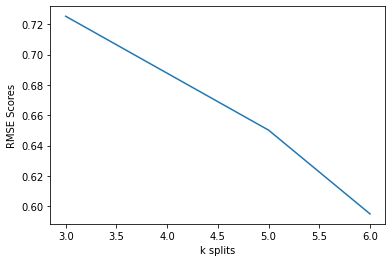

In [29]:
plot(kfolds_SVDpp, SVDpp_rmses, "SVDpp")

##Comparing SVD versus SVDpp

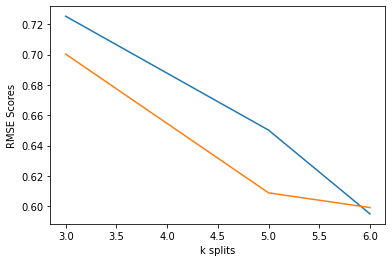

In [30]:
plt.plot(kfolds_SVDpp, SVDpp_rmses)
plt.plot(kfolds_SVD, SVD_rmses)
plt.ylabel('RMSE Scores')
plt.xlabel('k splits')
plt.savefig("SVD_versusus_SVDpp_RMSE_to_k_splits.png")